# Coursework 2: Fish Classification

Created by Athanasios Vlontzos and Wenjia Bai

In this coursework, you will be exploring the application of convolutional neural networks for image classification tasks. As opposed to standard applications such as object or face classification, we will be dealing with a slightly different domain, fish classification for precision fishing.

In precision fishing, engineers and fishmen collaborate to extract a wide variety of information about the fish, their species and wellbeing etc. using data from satellite images to drones surveying the fisheries. The goal of precision fishing is to provide the marine industry with information to support their decision making processes.

Here your will develop an image classification model that can classify fish species given input images. It consists of two tasks. The first task is to train a model for the following species:
- Black Sea Sprat
- Gilt-Head Bream
- Shrimp
- Striped Red Mullet
- Trout

The second task is to finetune the last layer of the trained model to adapt to some new species, including:
- Hourse Mackerel
- Red Mullet
- Red Sea Bream
- Sea Bass

You will be working using a large-scale fish dataset [1].

[1] O. Ulucan, D. Karakaya and M. Turkan. A large-scale dataset for fish segmentation and classification. Innovations in Intelligent Systems and Applications Conference (ASYU). 2020.

## Step 0: Download data.

[Download the Data from here -- make sure you access it with your Imperial account.](https://imperiallondon-my.sharepoint.com/:f:/g/personal/av2514_ic_ac_uk/EkA9HyXVvgdFoLI4P_IfO1cBO_CsvY1KN4NE8iuD-s_VlA?e=Ip03rF)

It is a ~2.5GB file. You can save the images and annotations directories in the same directory as this notebook or somewhere else.

The fish dataset contains 9 species of fishes. There are 1,000 images for each fish species, named as %05d.png in each subdirectory.

## Step 1: Load the data. (15 Points)

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [8]:
# Dependencies
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob

In [9]:
# We will start by building a dataset class using the following 5 species of fishes
Multiclass_labels_correspondances = {
    'Black Sea Sprat': 0,
    'Gilt-Head Bream': 1,
    'Shrimp': 2,
    'Striped Red Mullet': 3,
    'Trout': 4
}

# The 5 species will contain 5,000 images in total.
# Let us split the 5,000 images into training (80%) and test (20%) sets
def split_train_test(lendata, percentage=0.8):
    indices = list(range(0, lendata))
    np.random.shuffle(indices)
    train_len = int(lendata * percentage)
    idxs_train, idxs_test = indices[:train_len], indices[train_len:]
    return idxs_train, idxs_test

LENDATA = 5000
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)

# Implement the dataset class
class FishDataset(Dataset):
    def __init__(self,
                 path_to_images,
                 idxs_train,
                 idxs_test,
                 transform_extra=None,
                 img_size=128,
                 train=True):
        self.path_to_images = path_to_images      # path_to_images: where you put the fish dataset
        self.idxs_train = idxs_train              # idxs_train: training set indexes
        self.idxs_test = idxs_test                # idxs_test: test set indexes
        self.transform_extra = transform_extra    # transform_extra: extra data transform
        self.img_size = img_size                  # img_size: resize all images to a standard size
        self.train = train                        # train: return training set or test set
        
        copies = []
        for root, dirs, files in os.walk(self.path_to_images, topdown=False):
            for name in files:
                # Load all the images and their labels
                image = Image.open(os.path.join(root, name).replace("\\","/"))
                label = os.path.basename(root)
                if label in Multiclass_labels_correspondances:
                    label = Multiclass_labels_correspondances[label]

                    # scaling instead of cropping and resizing to prevent cropping of key interest points
                    image = image.resize((self.img_size, self.img_size))
                    image = image.copy()
                    to_tensor = transforms.ToTensor()
            
                    # Append copies list with tuple
                    copies.append((to_tensor(image), label))
                    image.close()

        # Extract the images and labels with the specified file indexes  
        self.training_set = [copies[i] for i in self.idxs_train]
        self.test_set = [copies[i] for i in self.idxs_test]
        
    def __len__(self):
        if (self.train == True):
            return(len(self.training_set))
        elif (self.train == False):
            return(len(self.test_set))
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the image and its label
        if (self.train == True):
            return(training_set[idx])
        elif (self.train == False):
            return(test_set[idx])

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

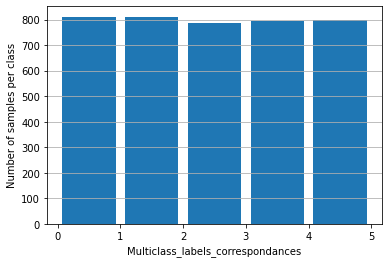

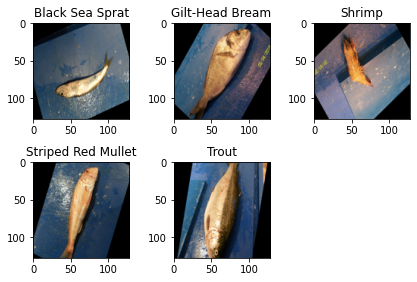

In [10]:
# Training set
img_path = './archive/Fish_Dataset/Fish_Dataset'
dataset  = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)
n = len(Multiclass_labels_correspondances)

# Plot the number of samples per class
training_set = dataset.training_set
bins = list(range(0, n+1))

plt.figure()
plt.hist([i[1] for i in training_set], density=False, bins=bins, rwidth=0.85)  
plt.grid(axis='y')
plt.xlabel('Multiclass_labels_correspondances')
plt.ylabel('Number of samples per class')

# Plot 1 sample from each of the five classes in the training set
sample_plots = []
r = np.random.randint(0, 750)
training_set.sort(key=lambda x:x[1])
for i in range(n):
    sample_plots.append(training_set[r + (800 * i)])

to_pil = transforms.ToPILImage()
plt.figure()
for i in range(n):
    plt.subplot(2,3,i+1)
    plt.imshow(np.asarray(to_pil(sample_plots[i][0])))
    plt.title(list(Multiclass_labels_correspondances.keys())[i])
    plt.tight_layout(pad=1.0)


### Step 2.2: Discussion. (10 points)

* Is the dataset balanced?

* Can you think of 3 ways to make the dataset balanced if it is not?

* Is the dataset already pre-processed? If yes, how?

#### ADD YOUR RESPONSE HERE ####

## Step 3: Multiclass classification. (55 points)
In this section we will try to make a multiclass classifier to determine the species of the fish.

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [18]:
class Net(nn.Module):
    def __init__(self, output_dims = 1):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1, padding = 0)
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Forward propagation
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = self.tanh(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)

        return x

# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = 'cpu'

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [19]:
# Network
model = Net().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Number of iterations for training
epochs = 10

# Training batch size
train_batch_size = 500

# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
train_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=train_batch_size, shuffle=True)

### Step 3.3: Train the model. (15 points)

Complete the training loop.

In [15]:
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    
    for imgs, labs in train_dataloader:
        # Get a batch of training data and train the model
        optimizer.zero_grad()

        imgs = imgs.to(device)
        labs = labs.to(device)
        
        labs_predicted, _ = model(imgs) 
        loss = criterion(labs_predicted, labs) 
        loss_curve += [loss.item()]

    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [6, 1, 5, 5], expected input[500, 3, 128, 128] to have 1 channels, but got 3 channels instead

### Step 3.4: Deploy the trained model onto the test set. (10 points)

In [ ]:
# Deploy the model
#### ADD YOUR CODE HERE ####


### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

In [ ]:
#### ADD YOUR CODE HERE ####


## Step 4: Finetune your classifier. (15 points)

In the previous section, you have built a pretty good classifier for certain species of fish. Now we are going to use this trained classifier and adapt it to classify a new set of species:

    'Hourse Mackerel
    'Red Mullet',
    'Red Sea Bream'
    'Sea Bass'

### Step 4.1: Set up the data for new species. (2 points)
Overwrite the labels correspondances so they only incude the new classes and regenerate the datasets and dataloaders.

In [ ]:
Multiclass_labels_correspondances ={
    'Hourse Mackerel': 0,
    'Red Mullet': 1,
    'Red Sea Bream': 2,
    'Sea Bass': 3}

LENDATA = 4000
idxs_train,idxs_test = split_train_test(LENDATA, 0.8)

# Dataloaders
#### ADD YOUR CODE HERE ####

### Step 4.2: Freeze the weights of all previous layers of the network except the last layer. (5 points)

You can freeze them by setting the gradient requirements to ```False```.

In [ ]:
def freeze_till_last(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_till_last(model)
# Modify the last layer. This layer is not freezed.
#### ADD YOUR CODE HERE ####

# Loss function
criterion =

# Optimiser and learning rate
lr =
optimizer =

# Number of iterations for training
epochs =

# Training batch size
train_batch_size =

### Step 4.3: Train and test your finetuned model. (5 points)

In [ ]:
# Finetune the model
for epoch in tqdm(range(epochs)):
    #### ADD YOUR CODE HERE ####

# Deploy the model on the test set
#### ADD YOUR CODE HERE ####

# Evaluate the performance
#### ADD YOUR CODE HERE ####

### Step 4.4: Did finetuning work? Why did we freeze the first few layers? (3 points)

#### ADD YOUR RESPONSE HERE ####